In [1]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
%matplotlib inline

In [2]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy', 'num_triggered_telescopes']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 0
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

print(gammas.columns)

Index(['gamma_prediction_mean', 'gamma_energy_prediction_mean',
       'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy',
       'num_triggered_telescopes', 'type', 'weight'],
      dtype='object')


In [3]:
gammas = gammas.query('num_triggered_telescopes >= 3')
protons = protons.query('num_triggered_telescopes >= 3')

In [4]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

gammas['theta'] = calculate_theta(gammas)
protons['theta'] = calculate_theta(protons)

In [19]:
def count_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum(), m.sum()


def select_events_in_energy_range(signal, background, e_low, e_high):
    m = ((signal.gamma_energy_prediction_mean > e_low ) & (signal.gamma_energy_prediction_mean < e_high ))
    s = signal[m]

    m = ((background.gamma_energy_prediction_mean > e_low ) & (background.gamma_energy_prediction_mean < e_high ))
    b = background[m]
    return s, b

def scaling_factor(n_signal, n_background, t_signal, t_background, alpha=1, N=200): 
    
    right_bound = 100
    min_n_signal = 10
    max_background_ratio = 0.05

    def target(scaling_factor, n_signal, n_background, alpha=1, sigma=5):
        n_on = n_background*alpha + n_signal * scaling_factor
        n_off = n_background
        
        significance = li_ma_significance(n_on, n_off, alpha=alpha)
        return (5 - significance)**2
    
    print(t_background, n_background, '---------', t_signal, n_signal)
    n_signal = np.random.poisson(t_signal, size=N) * n_signal / t_signal
    n_background = np.random.poisson(t_background, size=N) * n_background / t_background
    
    hs = []

    for signal, background in zip(n_signal, n_background):
        if background == 0:
            hs.append(np.nan)
        else:
            result = minimize_scalar(target, args=(signal, background, alpha), bounds=(0, right_bound), method='bounded').x
#             if signal < min_n_signal:
#                 print('not enough signal')
#                 result *= min_n_signal / signal
#             if signal < background*alpha * max_background_ratio:
#                 print('contaminated signal')
#                 result *= (background * max_background_ratio)/signal
            if np.allclose(result, right_bound):
                result = np.nan
            hs.append(result)
    return np.nanpercentile(np.array(hs), (50, 5, 95))


# regions=slice(0.015, 0.02, 0.0025), thresholds=slice(0.8, 9, 0.05)
#regions=slice(0.0025, 0.07, 0.0025), thresholds=slice(0.3, 1, 0.05)
def find_best_cuts(signal, background, alpha, regions=slice(0.0025, 0.07, 0.005), thresholds=slice(0.3, 1, 0.05)):

    def significance_target(cuts, signal, background, alpha):
        theta2, p_cut = cuts
        n_signal, t_signal = count_events_in_region(signal, theta2=theta2, prediction_threshold=p_cut)
        n_background, t_background = count_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)
        if t_background < 4:
#             print('Not enough counts')
            return 0
        if t_background*alpha + t_signal < 10::
            return 0
        if t_signal <= t_background + 10:
#             print('signal not large enough')
            return 0
#         print(n_signal*5, n_background*0.1)
        if n_signal*5 < n_background*0.1:
            print('sys problem')
            return 0
            
                
        n_on = n_signal + alpha*n_background
        n_off = n_background
        return -li_ma_significance(n_on, n_off, alpha=alpha)

    result = brute(significance_target, ranges=[regions, thresholds], args=(signal, background, alpha), finish=None)
    print(result)
    return result


def calc_relative_sensitivity(signal, background, bin_edges, alpha=1):
    relative_sensitivities = []
    for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
        s, b = select_events_in_energy_range(signal, background, e_low, e_high)
        
        theta2, cut = find_best_cuts(s, b, alpha=alpha)
        
        n_signal, t_signal = count_events_in_region(s, theta2=theta2, prediction_threshold=cut)
        n_background, t_background = count_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
        
        
        relative_sensitivities.append(scaling_factor(n_signal, n_background, t_signal, t_background, alpha=alpha))
    m, l, h = np.array(relative_sensitivities).T
    return pd.DataFrame({'sensitivity': m, 'sensitivity_low': l, 'sensitivity_high': h})



In [20]:
def plot_sensitivity(rs, crab, bin_edges, bin_center):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='')

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(bin_edges, crab.flux(bin_edges) * bin_edges**2, '--', color='gray')
    plt.ylim([1E-14, 1E-9])
    
    path = '../resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python')
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg/(u.cm**2 * u.s)

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black', label='reference')

    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')


-------------
only protons
[0.0025 0.3   ]
0 0.0 --------- 0 0.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


[0.0675 0.9   ]
1073 10239936.09161824 --------- 28102 406384.6341536122
[0.0425 0.8   ]
891 7214661.009599955 --------- 33516 354380.76016289194
[0.0225 0.85  ]
335 2126881.5196092837 --------- 45397 323182.1012185555
sys problem
sys problem
sys problem
sys problem
sys problem
[0.0225 0.85  ]
97 527981.5541492354 --------- 35899 176168.3303322528
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
sys problem
[0.0175 0.85  ]
15 103942.72675536301 --------- 17079 63145.40472638851
sys problem
[0.0075 0.8   ]
7 30785.675683605255 --------- 25235 70367.68100735862
[0.0075 0.75  ]
8 29174.62397241942 --------- 28257 57449.49571409083
[0.0325 0.75  ]
22 46255.85799727442 --------- 34541 51912.503430948316
[0.0175 0.75  ]
11 10735.838141963231 --------- 26247 29155.807085782606
[0.0075 0.65  ]


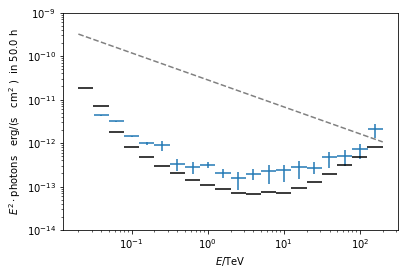

In [21]:
# rs = calc_relative_sensitivity(gammas, protons, bin_edges, alpha=0.1, optimize=True)
# plot_sensitivity(rs, crab, bin_edges, bin_center)

# print('with electrons')
# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2,)
# plot_sensitivity(rs, crab, bin_edges, bin_center)

print('-------------')
print('only protons')
rs = calc_relative_sensitivity(gammas, protons, bin_edges, alpha=0.1,)
plot_sensitivity(rs, crab, bin_edges, bin_center)


# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2, theta2=0.02, )
# plot_sensitivity(rs, crab, bin_edges, bin_center)

# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2, theta2=0.03, )
# plot_sensitivity(rs, crab, bin_edges, bin_center)

# # rs = calc_relative_sensitivity(signal, protons, bin_edges, alpha=0.2, theta2=0.03, )
# # plot_sensitivity(rs, crab, bin_edges, bin_center)
# # 

# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2, theta2=0.04, )
# plot_sensitivity(rs, crab, bin_edges, bin_center)
# rs = calc_relative_sensitivity(gammas, protons, bin_edges, alpha=0.2, optimize=False)
# plot_sensitivity(rs, crab, bin_edges, bin_center)

In [12]:
rs

,sensitivity,sensitivity_high,sensitivity_low
0,NaN,NaN,NaN
1,0.014213,0.014663,0.013689
2,0.012301,0.012942,0.011673
3,0.008191,0.008604,0.007807
4,0.007004,0.007715,0.006226
5,0.009504,0.011405,0.007433
6,0.004931,0.006052,0.003160
7,0.004410,0.005836,0.002272
8,0.008202,0.009678,0.006587
9,0.006857,0.008737,0.004878
